### the values are very close to each other, the fact that there are factors in the data almost changes nothing, as a result, the model prediction is random. I'm in the learning phase, so I decided to work on different types of data

In [1]:
#pip install scikit-learn

In [2]:
#import library
import matplotlib.pyplot as plt 
import seaborn as sns#visualization
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score#for accuracy
from sklearn.linear_model import LinearRegression
#for linear reg.[if you don't have the library install it:(pip install scikit-learn)]
df = pd.read_csv("/kaggle/input/road-accident-survival-dataset/accident.csv")
df.head()#we were able to get the data the first 5 lines for testing

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0


In [3]:
df_encoded = pd.get_dummies(df, drop_first=True)
print(df_encoded.isnull().sum())  
print(df_encoded.isin([np.inf, -np.inf]).sum())  
#checking and filling gaps in data

Age                  0
Speed_of_Impact      3
Survived             0
Gender_Male          0
Helmet_Used_Yes      0
Seatbelt_Used_Yes    0
dtype: int64
Age                  0
Speed_of_Impact      0
Survived             0
Gender_Male          0
Helmet_Used_Yes      0
Seatbelt_Used_Yes    0
dtype: int64


In [4]:
# Calculate the mean of "Speed_of_Impact"
mean_speed = df_encoded["Speed_of_Impact"].mean()

# Fill NaN values with the calculated mean
df_encoded["Speed_of_Impact"] = df_encoded["Speed_of_Impact"].fillna(mean_speed)


In [5]:
# Convert boolean (True/False) values to 0 and 1 for each column
df_encoded = df_encoded.apply(lambda x: x.map({True: 1, False: 0}) if x.dtype == 'bool' else x)

# Check the result
df_encoded.head()


,Age,Speed_of_Impact,Survived,Gender_Male,Helmet_Used_Yes,Seatbelt_Used_Yes
0,56,27.0,1,0,0,0
1,69,46.0,1,0,0,1
2,46,46.0,0,1,1,1
3,32,117.0,0,1,0,1
4,60,40.0,0,0,1,1


In [6]:
# Check the columns in the DataFrame
print(df_encoded.columns)


Index(['Age', 'Speed_of_Impact', 'Survived', 'Gender_Male', 'Helmet_Used_Yes',
       'Seatbelt_Used_Yes'],
      dtype='object')


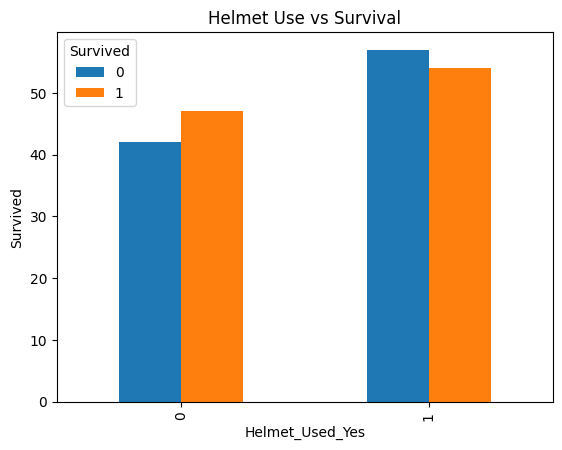

In [7]:
# Count the number of occurrences for each combination of 'Helmet_Used_Yes' and 'Survived'
helmet_survived_counts = df_encoded.groupby(['Helmet_Used_Yes', 'Survived']).size().unstack()

# Create a bar chart using matplotlib
helmet_survived_counts.plot(kind='bar', stacked=False)

# Set the labels and title
plt.xlabel("Helmet_Used_Yes")
plt.ylabel("Survived")
plt.title("Helmet Use vs Survival")

# Show the plot
plt.show()


## the death of helmet users in this datada is more contrary to what is expected, now let's proceed with the random forest method to get more accurate results during training

In [8]:
# Define X (features) and y (target)
X = df_encoded.drop("Survived", axis=1)  # Remove the target variable
y = df_encoded["Survived"]  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Create a Random Forest model with class weighting to handle imbalance
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [10]:
# Make predictions with the model
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for class 1

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc}")


AUC-ROC: 0.5151515151515151


In [11]:
#As an explanation, the result came out below expectations, so let's check the tables to identify where the mistake occurred.

## We got a lower value than expected, let's check the correlation heatmap to see if there are any issues with the relationships.

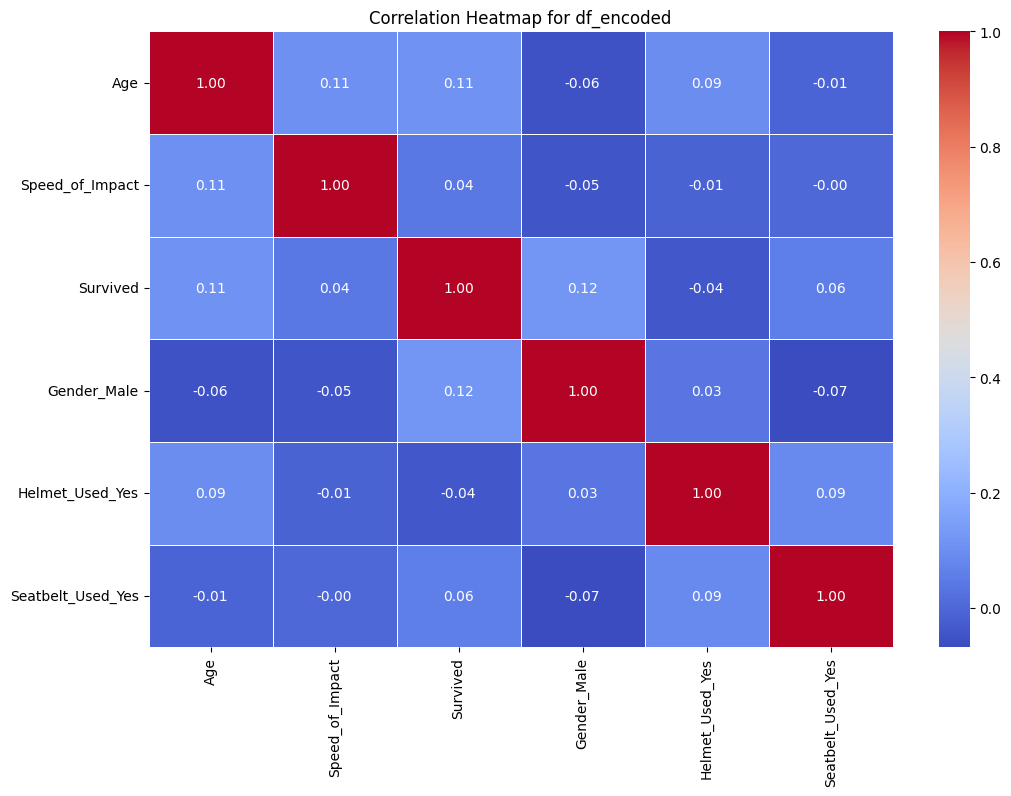

In [12]:
# Calculate the correlation matrix (for all numerical columns)
corr = df_encoded.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for df_encoded')
plt.show()

## As we noticed earlier, there seems to be an issue with the results for helmet users, and normally the opposite should be true. Therefore, let's modify the results for helmet users.

In [13]:
# Invert the values of the Helmet_Used_Yes column
df_encoded['Helmet_Used_Yes'] = df_encoded['Helmet_Used_Yes'].apply(lambda x: 1 if x == 0 else 0)

# Check the changes
print(df_encoded[['Helmet_Used_Yes']].head())


   Helmet_Used_Yes
0                1
1                1
2                0
3                1
4                0


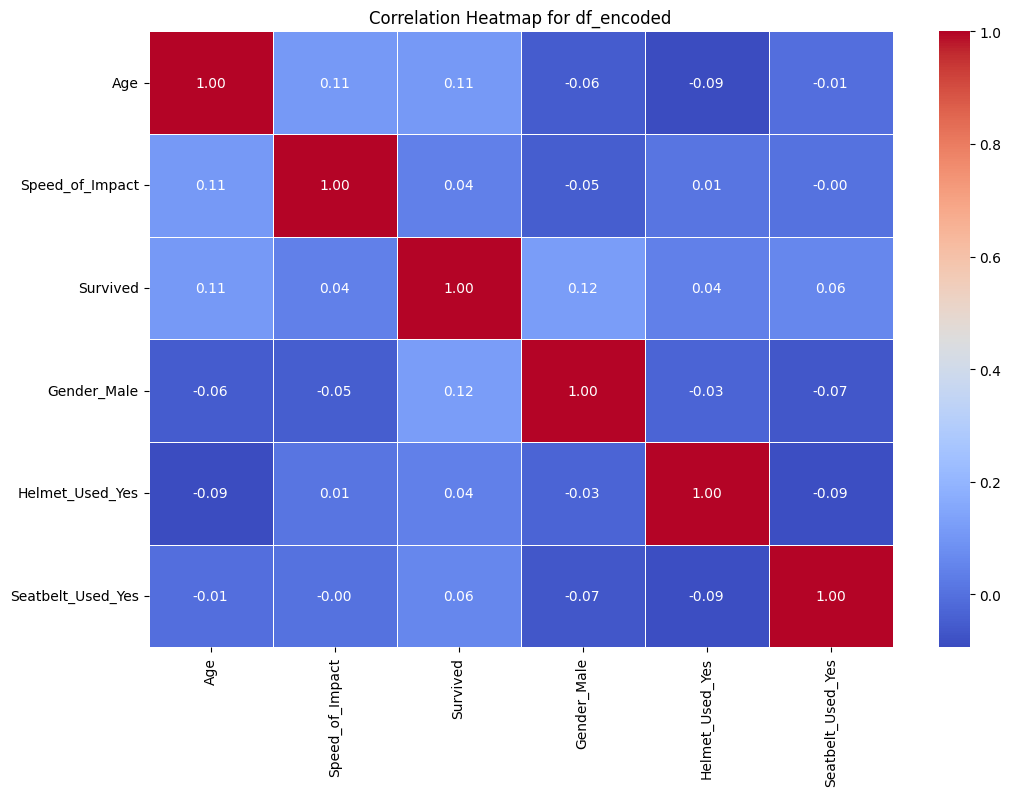

In [14]:
# Calculate the correlation matrix (for all numerical columns)
corr = df_encoded.corr()

# Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap for df_encoded')
plt.show()

## Now that helmet usage positively affects survival, let's retrain the model and test it again.

In [15]:
# Define X (features) and y (target)
X = df_encoded.drop("Survived", axis=1)  # Remove the target variable
y = df_encoded["Survived"]  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# Create a Random Forest model with class weighting to handle imbalance
model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Train the model
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

In [17]:
# Make predictions with the model
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability estimates for class 1

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {roc_auc}")


AUC-ROC: 0.5176767676767676


# I would be happy if someone more experienced could comment and point out my mistake, thank you in advance